In [1]:
import numpy as np
import os
import glob
import random
import cv2
import shutil
import matplotlib.pyplot as plt
from keras.datasets import mnist
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose
from keras.models import Model
from keras.preprocessing import image

In [2]:
def get_id(subject):
    sub = str(subject)
    if(len(sub)==1): sub = '00' + sub
    elif(len(sub)==2): sub = '0' + sub
    return sub

subjects = 124
subject_ids = [get_id(i) for i in range(1, subjects+1)] 
conditions = ['bg-01', 'bg-02', 'cl-01', 'cl-02', 'nm-01', 'nm-02', 'nm-03', 'nm-04', 'nm-05', 'nm-06']


In [5]:
classes = []
for i in range(74):
    label = random.choice(subject_ids)
    while label in classes:
        label = random.choice(subject_ids)
    classes.append(label)

files = glob.glob('./training_data/*')
for f in files:
    shutil.rmtree(f)

for cls in classes:
    os.mkdir('./training_data/%s'%cls)
    files = glob.glob('./GEIs/%s/*'%cls)
    for file in files:
        shutil.copy(file, './training_data/%s/'%cls)

In [6]:
files = glob.glob('./testing_data/*')
for f in files:
    shutil.rmtree(f)

for sub in subject_ids:
    if sub not in classes:
        os.mkdir('./testing_data/%s'%sub)
        files = glob.glob('./GEIs/%s/*'%sub)
        for file in files:
            shutil.copy(file, './testing_data/%s/'%sub)

In [3]:
X_train = []

subs = os.listdir('./training_data/')

for sub in subs:
    files= os.listdir('./training_data/%s'%sub)
    for file in files:
        path = './training_data/' + sub + '/' + file
        img = cv2.imread(path)
        X_train.append(img / 255)

In [4]:
X_test = []

subs = os.listdir('./testing_data/')

for sub in subs:
    files= os.listdir('./testing_data/%s'%sub)
    for file in files:
        path = './testing_data/' + sub + '/' + file
        img = cv2.imread(path)
        X_test.append(img / 255)

In [5]:
X_train = np.array(X_train)
X_test = np.array(X_test)

In [6]:
print(X_train.shape, X_test.shape)

(23908, 88, 128, 3) (15673, 88, 128, 3)


In [11]:
(X_train, _), (X_test, _) = mnist.load_data()
print(X_train.shape, X_test.shape)

(60000, 28, 28) (10000, 28, 28)


In [7]:
def show_data(X, n=10, h=88, w=128, title=""):
    plt.figure(figsize=(10, 3))
    for i in range(n):
        ax = plt.subplot(2,n,i+1)
        if(h != 88): plt.imshow(X[i].reshape((64, 352)))
        else: plt.imshow(X[i])

        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.suptitle(title, fontsize = 20)

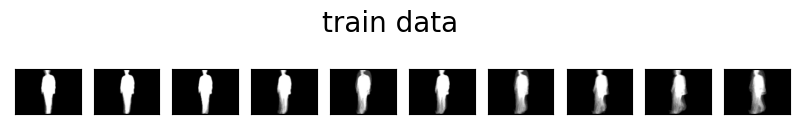

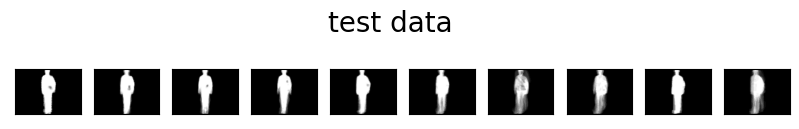

In [8]:
show_data(X_train, title="train data")
show_data(X_test, title="test data")

In [9]:
input_layer = Input(shape=(88, 128, 3), name="INPUT")
x = Conv2D(40, (3, 3), activation='relu', padding='same')(input_layer)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(32, (5, 5), activation='relu', padding='same')(x)
code_layer = MaxPooling2D((2, 2), name="CODE")(x)

x = Conv2DTranspose(32, (5, 5), activation='relu', padding='same')(code_layer)
x = UpSampling2D((2, 2))(x)
x = Conv2DTranspose(40, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)

output_layer = Conv2D(3, (3, 3), padding='same', name="OUTPUT")(x)

In [10]:
# Autoencoder
autoencoder = Model(input_layer, output_layer)
autoencoder.compile(optimizer="adam", loss="binary_crossentropy")
# autoencoder.summary()

In [11]:
x = X_train

In [12]:
autoencoder.fit(x=x, y=x, epochs=1)

748/748 [==============================] - 661s 878ms/step - loss: 0.0922


In [13]:
d = autoencoder.predict(x)

MemoryError: Unable to allocate 3.01 GiB for an array with shape (23908, 88, 128, 3) and data type float32

In [22]:
get_encoded_data = Model(inputs=autoencoder.input, outputs=autoencoder.get_layer("CODE").output)

In [32]:
e = get_encoded_data.predict(x)
e = e.reshape((len(x), 32*32*22))


32/32 [==============================] - 2s 47ms/step


In [40]:
for i in e:
    print(i.reshape((64, 352)))

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ...

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

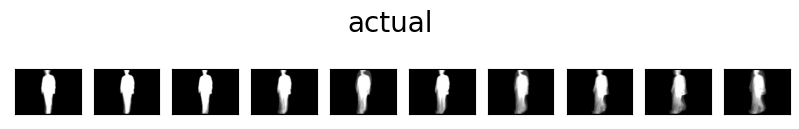

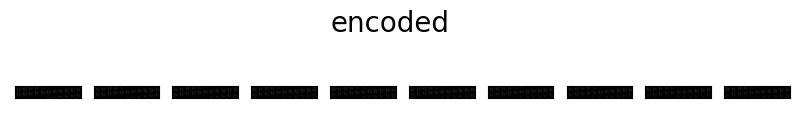

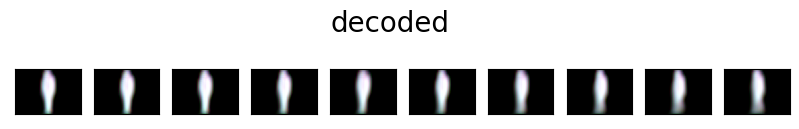

In [44]:
show_data(x, title="actual")
show_data(e, h=64, w=352, title="encoded")
show_data(d, title="decoded")

In [63]:
img_height = 88
img_width = 128

epochs = 100
batch_size = 64
val_split = 0.2

f1 = 40; k1 = 3; s1 = 2
f2 = 32; k2 = 5; s2 = 3

In [71]:
input = layers.Input(shape=(28, 28, 1))

# Encoder
x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(input)
x = layers.MaxPooling2D((2, 2), padding="same")(x)
x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(x)
x = layers.MaxPooling2D((2, 2), padding="same")(x)

# Decoder
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2D(1, (3, 3), activation="sigmoid", padding="same")(x)

# Autoencoder
autoencoder = Model(input, x)
autoencoder.compile(optimizer="adam", loss="binary_crossentropy")
autoencoder.summary()

Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_29 (Conv2D)          (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 14, 14, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_30 (Conv2D)          (None, 14, 14, 32)        9248      
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 7, 7, 32)         0         
 g2D)                                                            
                                                                 
 conv2d_transpose_25 (Conv2D  (None, 14, 14, 32)       924